# Описание ДЗ-3.

В третьей домашке необходимо для датасета животных обучить MLP.
2. Использовать Custom Dataset, Sampler, collate_fn
3. Сделать предобработку фичей
4. Попробовать BatchNorm1d, Dropout
5. Подключить для логирования tensorboard и/или mlflow
6. Не забыть разделить выборку на train/valid в соотношении 80/20%
7. Получить точность не ниже 65%.
8. Сравнить результаты при разных подходах: 1) Масштабировать данные StandardScaler'ом + не использовать BatchNorm после Input слоя 2) Не Масштабировать данные + использовать BatchNorm после Input слоя 3) StandardScaler + BatchNorm

*В папке LESS  можно найти примеры использования всех необходимых либ для выполнения данной работы*

За дз можно получить максимум 15 баллов. **Домашки довольно творческие, если замечу копию нотбука у другого студента то максимальный балл сниижается до 3 )**

Разбалловка:
*   **Воспроизводимость и читабельность кода -  11 баллов** (все воспроизвелось и все понятно для проверяющего - 11 баллов; есть непонятные моменты, но все воспроизвелось - 6 балла; непонятный код и/или воспроизводится с небольшой правкой - 3 балл; непонятный код и/или ничего не воспроизвелось - 0 баллов).
*   **Технический отчет - 4 балла** (приведены результаты сравнения и выводы что сделали чтоб перебить baseline\другую модель, к примеру одна модель лучше/хуже нейронки и тд - 4 балла, только результаты - 2 балл, ничего нет - 0 баллов).


**Присылать домашки по ссылке https://forms.gle/W8jwbwA4EWagEbX66**

In [1]:
!pip install torchmetrics mlflow tensorboard --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.7/733.7 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.4/118.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 12.1 MB/s eta 0:00:00


In [164]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Sampler
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import random
import os
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
SEED = 42

In [122]:
def read_df():
  X = pd.read_csv('/content/drive/MyDrive/data/X_cat.csv', sep='\t', index_col=[0])
  y = pd.read_csv('/content/drive/MyDrive/data/y_cat.csv', sep='\t', index_col=[0], header=None)

  y = y.rename(columns={1: 'label'})

  df = pd.concat([X, y], axis=1)

  return df


In [157]:
df = read_df()

### EDA

In [124]:
df.head()

,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,label
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,...,0,0,0,0,1,0,0,0,0,Return_to_owner
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,...,0,0,0,0,0,0,0,0,1,Euthanasia
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,...,0,0,0,0,0,0,0,1,0,Adoption
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,...,1,0,0,0,0,0,1,0,0,Transfer
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,...,0,0,0,0,0,0,1,0,0,Transfer


In [125]:
df['label'].value_counts()

,count
label,
Adoption,10769
Transfer,9422
Return_to_owner,4786
Euthanasia,1555
Died,197


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26729 entries, 0 to 26728
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   IsDog                           26729 non-null  int64  
 1   Age                             26729 non-null  float64
 2   HasName                         26729 non-null  int64  
 3   NameLength                      26729 non-null  int64  
 4   NameFreq                        26729 non-null  float64
 5   MixColor                        26729 non-null  int64  
 6   ColorFreqAsIs                   26729 non-null  float64
 7   ColorFreqBase                   26729 non-null  float64
 8   TabbyColor                      26729 non-null  int64  
 9   MixBreed                        26729 non-null  int64  
 10  Domestic                        26729 non-null  int64  
 11  Shorthair                       26729 non-null  int64  
 12  Longhair                        26729

In [34]:
df.describe()

,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
count,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,...,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000
mean,0.583449,794.027550,0.712260,5.992069,0.082689,0.520932,0.035786,0.256777,0.194171,0.834225,...,0.695836,0.263235,0.040929,0.139175,0.143515,0.131393,0.126118,0.134274,0.163568,0.161959
std,0.492996,1082.433952,0.452718,1.544733,0.129147,0.499571,0.033190,0.173059,0.395569,0.371885,...,0.460061,0.440397,0.198130,0.346135,0.350603,0.337836,0.331988,0.340952,0.369890,0.368420
min,0.000000,1.000000,0.000000,1.000000,0.000026,0.000000,0.000026,0.000052,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,60.000000,0.000000,5.000000,0.000105,0.000000,0.012413,0.075353,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,365.000000,1.000000,6.000000,0.000576,1.000000,0.024748,0.274622,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1095.000000,1.000000,7.000000,0.285871,1.000000,0.061778,0.463624,0.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,7300.000000,1.000000,12.000000,0.285871,1.000000,0.105879,0.598205,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
df.isna().sum()

,0
IsDog,0
Age,0
HasName,0
NameLength,0
NameFreq,0
MixColor,0
ColorFreqAsIs,0
ColorFreqBase,0
TabbyColor,0
MixBreed,0


Закодируем таргет с помощью LabelEncoder

In [158]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

In [144]:
le.classes_

array(['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'],
      dtype=object)

<Axes: >

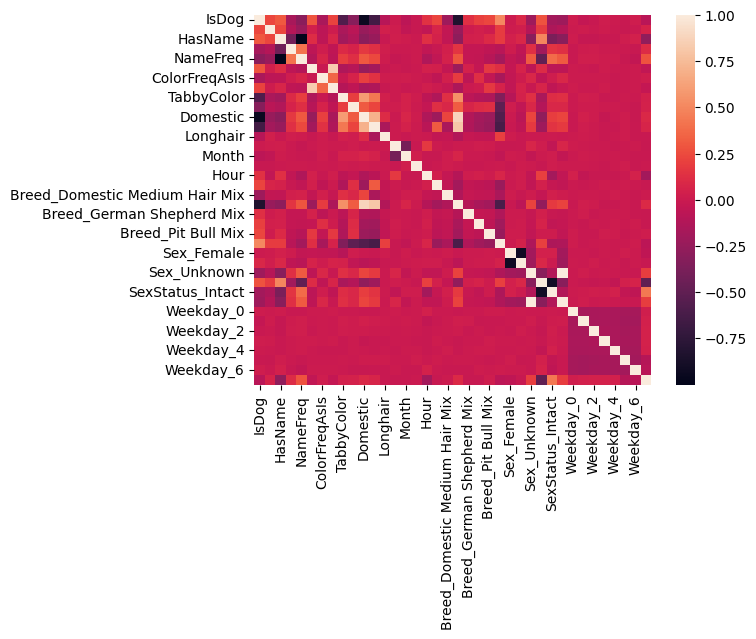

In [145]:
sns.heatmap(df.corr(numeric_only=True))

Удалим фичи, у которых высокая корреляция с другими фичами, либо низкая корреляция с таргетом

In [159]:
corr_matrix = df.corr(numeric_only=True)

target_corr = corr_matrix['label'].abs().sort_values(ascending=False)
corr_matrix = corr_matrix.drop('label')

feature_corr_threshold = 0.95

target_corr_threshold = 0.05

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column].abs() > feature_corr_threshold)]


low_target_corr_features = target_corr[np.abs(target_corr) < target_corr_threshold].index.tolist()

to_drop = to_drop + low_target_corr_features

print(f"{to_drop}")

['NameFreq', 'SexStatus_Unknown', 'MixBreed', 'Weekday_2', 'Weekday_1', 'TabbyColor', 'Weekday_4', 'ColorFreqBase', 'Weekday_0', 'ColorFreqAsIs', 'Breed_Pit Bull Mix', 'Breed_Chihuahua Shorthair Mix', 'Sex_Male', 'Breed_Labrador Retriever Mix', 'Year', 'Breed_German Shepherd Mix', 'Month', 'Longhair', 'Day', 'Breed_Domestic Medium Hair Mix']


In [160]:
df = df.drop(to_drop, axis=1)

In [76]:
df.head()

,IsDog,Age,HasName,NameLength,MixColor,Shorthair,Hour,Breed_Domestic Shorthair Mix,Breed_Rare,Sex_Female,Sex_Unknown,SexStatus_Flawed,Weekday_3,Weekday_5,Weekday_6,label
0,1,365.0,1,7,1,0,14.366667,0,1,0,0,1,0,0,0,3
1,0,365.0,1,5,0,1,8.733333,1,0,1,0,1,0,0,1,2
2,1,730.0,1,6,1,0,9.466667,0,0,0,0,1,0,1,0,0
3,0,21.0,0,7,0,1,15.150000,1,0,0,0,0,0,0,0,4
4,1,730.0,0,7,0,0,8.866667,0,1,0,0,1,0,0,0,4


### Custom Dataset, Sampler

In [78]:
class MySampler(Sampler):
  def __init__(self, data, shuffle=True, generator=None):
    self.data = data
    self.shuffle = shuffle
    self.generator = generator

  def __iter__(self):
    indices = np.arange(len(self.data))
    if self.shuffle:
      if self.generator is not None:
        perm = torch.randperm(len(indices), generator=self.generator).tolist()
        return iter(perm)
      else:
        np.random.shuffle(indices)
    return iter(indices)

  def __len__(self):
    return len(self.data)

In [79]:
class MyDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [82]:
def collate_fn(batch):
  X, y = zip(*batch)
  X = torch.tensor(X)
  y = torch.tensor(y)
  return X, y

In [101]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim, batch_norm=False):
    super().__init__()
    self.fc1 = nn.Linear(input_dim, 128)
    self.fc2 = nn.Linear(128, 256)
    self.fc3 = nn.Linear(256, 64)
    self.fc4 = nn.Linear(64 + input_dim, output_dim)
    self.bnl = nn.BatchNorm1d(256) if batch_norm else nn.Identity()

  def forward(self, x_raw):
    x = torch.relu(self.fc1(x_raw))
    x = torch.relu(self.fc2(x))
    x = self.bnl(x)
    x = torch.relu(self.fc3(x))
    x = torch.cat((x, x_raw), dim=1)
    x = self.fc4(x)
    return x



### Train NN functions

In [107]:
def train_epoch(model, loader, optimizer, criterion, device):
  model.train()
  train_loss = 0
  train_acc = 0

  for X, y in loader:
    X = X.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(y_pred.data, 1)
    train_acc += (predicted == y).sum().item()

  epoch_loss = train_loss / len(loader.dataset)
  epoch_acc = train_acc / len(loader.dataset)

  return epoch_loss, epoch_acc


In [106]:
def eval_epoch(model, loader, criterion, device):
  model.eval()
  valid_loss = 0
  valid_acc = 0
  with torch.no_grad():
    for X, y in loader:
      X = X.to(device)
      y = y.to(device)

      y_pred = model(X)
      loss = criterion(y_pred, y)
      valid_loss += loss.item()
      _, predicted = torch.max(y_pred.data, 1)
      valid_acc += (predicted == y).sum().item()

  epoch_loss = valid_loss / len(loader.dataset)
  epoch_acc = valid_acc / len(loader.dataset)

  return epoch_loss, epoch_acc

In [118]:
def train(X, y, device, num_epochs, m_type, preprocess=False, batch_norm=False):
  SEED = 42
  torch.manual_seed(SEED)
  np.random.seed(SEED)
  random.seed(SEED)
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED)


  if preprocess:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)


  train_dataset = MyDataset(X_train, y_train)
  valid_dataset = MyDataset(X_valid, y_valid)

  train_sampler = MySampler(train_dataset, shuffle=True)
  valid_sampler = MySampler(valid_dataset, shuffle=False)

  train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler, collate_fn=collate_fn)
  valid_loader = DataLoader(valid_dataset, batch_size=16, sampler=valid_sampler, collate_fn=collate_fn)

  input_dim = X_train.shape[1]
  output_dim = len(le.classes_)

  model = MLP(input_dim, output_dim, batch_norm=batch_norm).to(device)
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  writer = SummaryWriter(f'runs/{m_type}')
  losses = []
  accuracies = []

  valid_losses = []
  valid_accuracies = []

  for epoch in tqdm(range(num_epochs), desc=f"Training epochs - Model {m_type}"):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = eval_epoch(model, valid_loader, criterion, device)

    losses.append(train_loss)
    accuracies.append(train_acc)

    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Loss/valid', valid_loss, epoch)
    writer.add_scalar('Accuracy/valid', valid_acc, epoch)

    tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

  writer.close()

### Обучение

Нормализация

In [161]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X = df.drop('label', axis=1).values.astype(np.float32)
y = df['label'].values
num_epochs = 8

train(X, y, device, num_epochs, 'normalization without batch_norm', preprocess=True, batch_norm=False)

Training epochs - Model normalization without batch_norm:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/8 - Train Loss: 0.0565, Train Acc: 0.6381, Valid Loss: 0.0542, Valid Acc: 0.6521
Epoch 2/8 - Train Loss: 0.0529, Train Acc: 0.6600, Valid Loss: 0.0523, Valid Acc: 0.6640
Epoch 3/8 - Train Loss: 0.0513, Train Acc: 0.6685, Valid Loss: 0.0511, Valid Acc: 0.6594
Epoch 4/8 - Train Loss: 0.0505, Train Acc: 0.6735, Valid Loss: 0.0509, Valid Acc: 0.6646
Epoch 5/8 - Train Loss: 0.0500, Train Acc: 0.6741, Valid Loss: 0.0512, Valid Acc: 0.6626
Epoch 6/8 - Train Loss: 0.0494, Train Acc: 0.6781, Valid Loss: 0.0505, Valid Acc: 0.6715
Epoch 7/8 - Train Loss: 0.0490, Train Acc: 0.6797, Valid Loss: 0.0508, Valid Acc: 0.6667
Epoch 8/8 - Train Loss: 0.0485, Train Acc: 0.6814, Valid Loss: 0.0507, Valid Acc: 0.6704


Без нормализации

In [162]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X = df.drop('label', axis=1).values.astype(np.float32)
y = df['label'].values
num_epochs = 8

train(X, y, device, num_epochs, 'without normalization, with batch_norm', preprocess=False, batch_norm=True)

Training epochs - Model without normalization, with batch_norm:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/8 - Train Loss: 0.1935, Train Acc: 0.5663, Valid Loss: 0.0662, Valid Acc: 0.6008
Epoch 2/8 - Train Loss: 0.0661, Train Acc: 0.6111, Valid Loss: 0.0782, Valid Acc: 0.5552
Epoch 3/8 - Train Loss: 0.0670, Train Acc: 0.6146, Valid Loss: 0.1014, Valid Acc: 0.6175
Epoch 4/8 - Train Loss: 0.0649, Train Acc: 0.6193, Valid Loss: 0.0650, Valid Acc: 0.6332
Epoch 5/8 - Train Loss: 0.0657, Train Acc: 0.6156, Valid Loss: 0.0613, Valid Acc: 0.6362
Epoch 6/8 - Train Loss: 0.0635, Train Acc: 0.6208, Valid Loss: 0.0626, Valid Acc: 0.6394
Epoch 7/8 - Train Loss: 0.0649, Train Acc: 0.6196, Valid Loss: 0.0592, Valid Acc: 0.6053
Epoch 8/8 - Train Loss: 0.0644, Train Acc: 0.6173, Valid Loss: 0.0650, Valid Acc: 0.6081


Нормализация + BatchNorm

In [163]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X = df.drop('label', axis=1).values.astype(np.float32)
y = df['label'].values
num_epochs = 8

train(X, y, device, num_epochs, 'with normalization, with batch_norm', preprocess=True, batch_norm=True)

Training epochs - Model with normalization, with batch_norm:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/8 - Train Loss: 0.0569, Train Acc: 0.6375, Valid Loss: 0.0537, Valid Acc: 0.6521
Epoch 2/8 - Train Loss: 0.0530, Train Acc: 0.6601, Valid Loss: 0.0521, Valid Acc: 0.6633
Epoch 3/8 - Train Loss: 0.0518, Train Acc: 0.6661, Valid Loss: 0.0516, Valid Acc: 0.6568
Epoch 4/8 - Train Loss: 0.0512, Train Acc: 0.6681, Valid Loss: 0.0514, Valid Acc: 0.6665
Epoch 5/8 - Train Loss: 0.0507, Train Acc: 0.6716, Valid Loss: 0.0513, Valid Acc: 0.6642
Epoch 6/8 - Train Loss: 0.0503, Train Acc: 0.6747, Valid Loss: 0.0506, Valid Acc: 0.6676
Epoch 7/8 - Train Loss: 0.0501, Train Acc: 0.6742, Valid Loss: 0.0513, Valid Acc: 0.6646
Epoch 8/8 - Train Loss: 0.0497, Train Acc: 0.6746, Valid Loss: 0.0505, Valid Acc: 0.6710


### Вывод

При подготовке данных, были удалены фичи, у которых высокая >0.95 абсолютная корреляция с другими признаким, либо низкая абсолютная корреляция с таргетом <0.05. Это позволило немного увеличить точность модели

Лучше всего себя показала модель с нормализацией и batch normalization с точностью 0.671.       
Хуже всего себя показала модель без нормализации - 0.6.       
Модель с нормализацией и без batch normalization модель приблизительно показала себя как лучшая модель ~0.6704.   
Получается batch normalization почти не влияет на качество модели